In [1]:
# Adapted from: https://github.com/crispitagorico/Hall-areas/blob/master/Sig-inversion%20through%20Legendre%20polynomials.ipynb
import numpy as np
from main_funcs import Jacobi, Legendre, Chebyshev, Hermite, Fourier
from free_lie_algebra import * 
import matplotlib.pyplot as plt
from tqdm import tqdm

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### inverting signature by orthogonal polynomials

In [2]:
# verify recurrence relation of signature
length = 200
t_grid = np.linspace(-1, 1, length)

def x_(t):
    return np.cos(15*t) - np.sin(3*t)
def x(t):
    return x_(t) - x_(-1)

N = 15
trunc_sig = N + 2

poly = Jacobi(0.5, 0.5)
path_poly = poly.ploy2path(x, N, t_grid)

path = x(t_grid)
path_time = np.c_[t_grid, path*poly.weight(t_grid)]

sig = signature_of_path_iisignature(path_time, trunc_sig)

path_sig = poly.sig2path(sig, N, t_grid)

e:\File_VSCode\M3R\M3R_LMU\main_funcs.py:116: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  an = quad(lambda t: x(t)*P_n(t)*self.weight(t), self.x1, self.x2)[0]/snorm_n
e:\File_VSCode\M3R\M3R_LMU\main_funcs.py:149: RuntimeWarning: divide by zero encountered in divide
  return sig_map(t_grid) / self.weight(t_grid)


In [3]:
for n in range(N):
    print((poly.a_sig(sig, n)-poly.a(x, n))**2)

2.3815498678581882e-09
2.1143916168640336e-08
9.168638499353928e-08
2.485875469343975e-08
6.692503483024273e-07
2.1939451885005014e-07
3.291756693694893e-06
4.970909533292253e-07
9.474075795916072e-06
9.02890712851477e-07
5.557066026248266e-06
1.3862083523713585e-06
9.252839924685261e-07
1.8946227609542305e-06
2.2434080441331228e-05


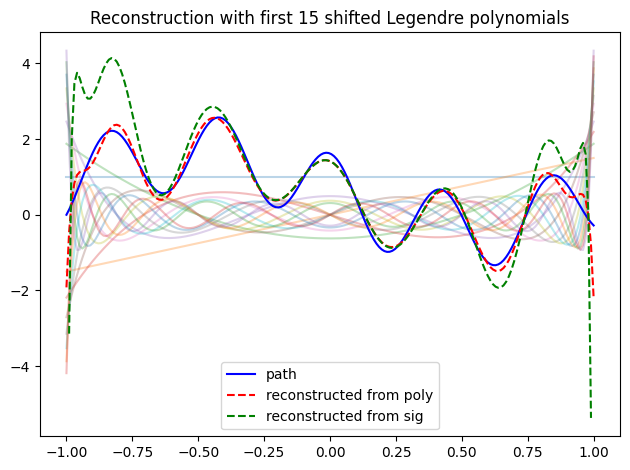

In [4]:
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, path, label='path', c='blue')
plt.plot(t_grid, path_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, path_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()

In [5]:
# try recurrence relation of signature for high frequency sigals
def x_(t):
    return np.cos(35*t) - np.sin(5*t)
def x(t):
    return x_(t) - x_(-1)

N = 15
trunc_sig = N + 2

poly = Jacobi(0, 0)
path_poly = poly.ploy2path(x, N, t_grid)

path = x(t_grid)
path_time = np.c_[t_grid, path*poly.weight(t_grid)]

sig = signature_of_path_iisignature(path_time, trunc_sig)

path_sig = poly.sig2path(sig, N, t_grid)

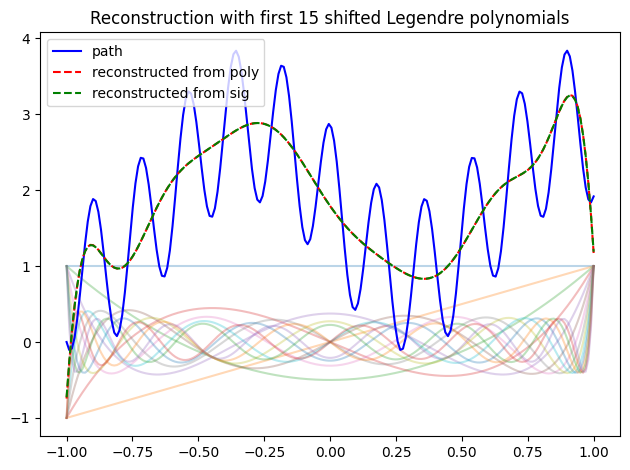

In [6]:
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, path, label='path', c='blue')
plt.plot(t_grid, path_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, path_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()

### Point-wise estimate of path based on orthogonal polynomials

In [2]:
# construct a random function
def random_sine_generator(seed=1531):
    np.random.seed(seed)
    freq = np.random.normal(np.random.uniform(5, 10), np.random.uniform(2, 5), size=np.random.randint(2, 10))
    def func(t):
        if isinstance(t, float):
            return sum(np.sin(freq*t))
        else:
            return np.sum(np.sin(np.outer(freq, t)), axis=0)
    return func

Original point:  -3.7934176718654595
Hermite estimate:  -3.7764906601701838
Jacobi estimate:  -0.041263389040478826


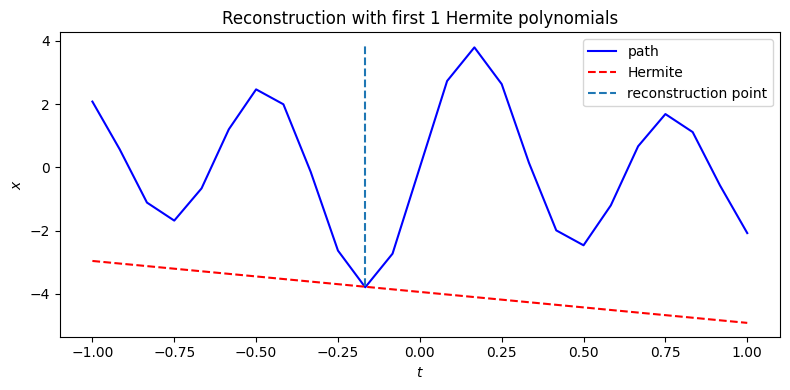

In [8]:
length = 25
t_grid = np.linspace(-1, 1, length)
t0 = t_grid[10]
eps = 0.01

func = random_sine_generator(seed=np.random.randint(1, 10000))
def x_(t):
    # return np.exp(-t**2/2)
    return func(t)
# def x(t):
#     return x_(t) - x_(-1)

N = 1

hpoly = Hermite(t0, eps)
path_hpoly = hpoly.ploy2path(x_, N, t0)
jpoly = Jacobi(1, 1)
path_jpoly = jpoly.ploy2path(x_, N, t0)
print('Original point: ', x_(t0))
print('Hermite estimate: ', path_hpoly)
print('Jacobi estimate: ', path_jpoly)

plt.figure(figsize=(8, 4), dpi=100)
# for n in range(N):
#     plt.plot(t_grid, hpoly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, x_(t_grid), label='path', c='blue')
plt.plot(t_grid, hpoly.ploy2path(x_, N, t_grid), label='Hermite', c='red', linestyle='--')
plt.vlines(t0, min(x_(t_grid))*0.99, max(x_(t_grid))*1.01, linestyles='dashed', label='reconstruction point')
plt.legend()
plt.title(f'Reconstruction with first {N} Hermite polynomials')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.tight_layout()

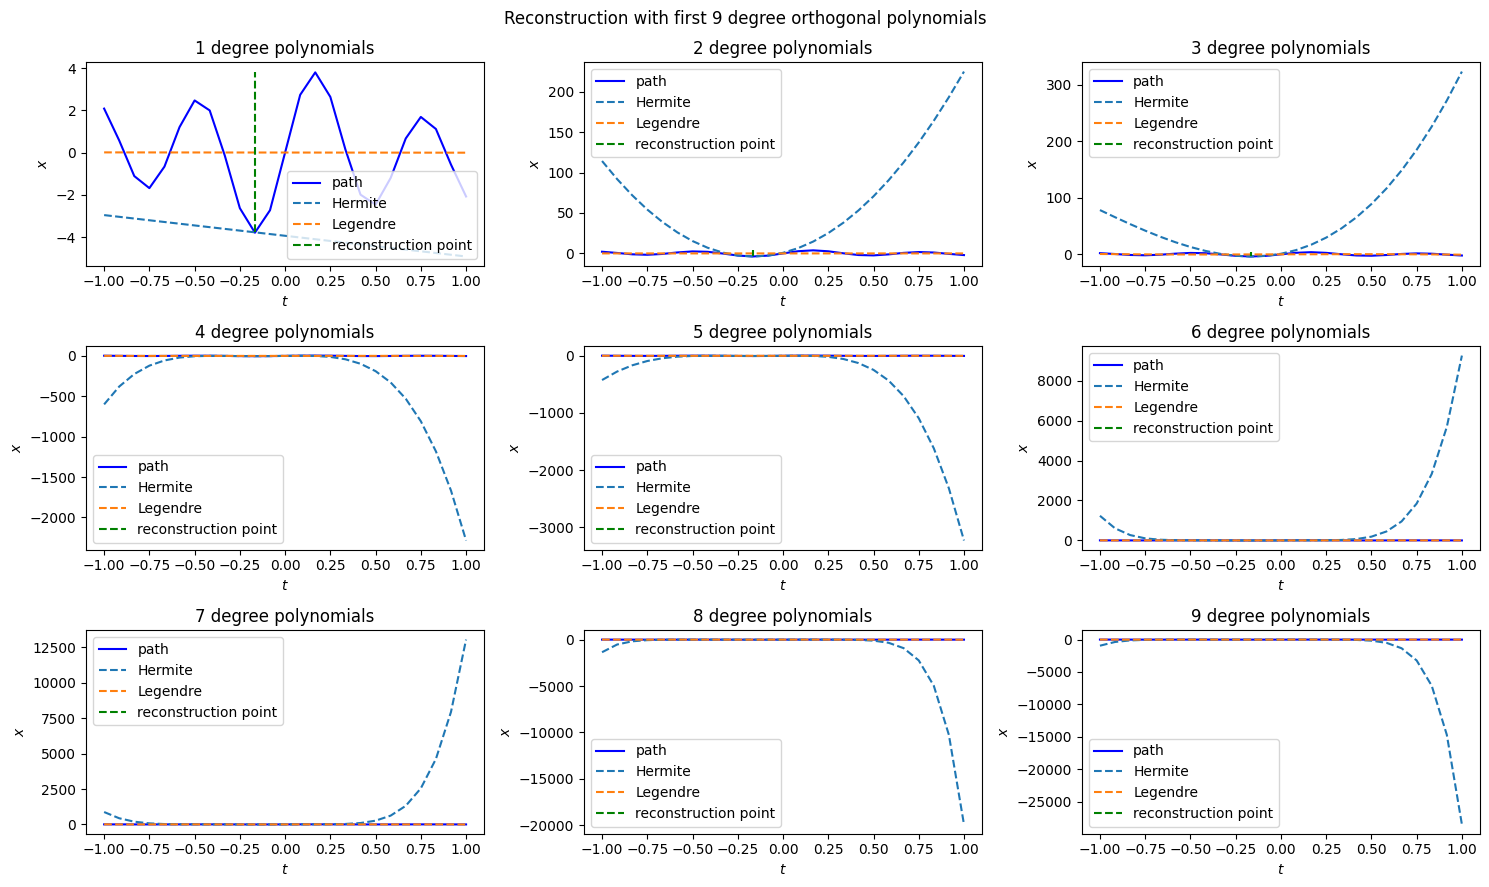

In [9]:
# visualisation of Hermite compared with legendre
plt.figure(figsize=(15, 9), dpi=100)
for n in range(1, 10):
    plt.subplot(3, 3, n)
    hpoly = Hermite(t0, eps)
    jpoly = Legendre()

    plt.plot(t_grid, x_(t_grid), label='path', c='blue')
    plt.plot(t_grid, hpoly.ploy2path(x_, n, t_grid), label='Hermite', linestyle='--')
    plt.plot(t_grid, jpoly.ploy2path(x_, n, t_grid), label='Legendre', linestyle='--')
    plt.vlines(t0, min(x_(t_grid))*0.99, max(x_(t_grid))*1.01, linestyles='dashed', colors='g', label='reconstruction point')
    plt.title(f'{n} degree polynomials')
    plt.legend()
    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
plt.suptitle(f'Reconstruction with first 9 degree orthogonal polynomials')
plt.tight_layout()

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


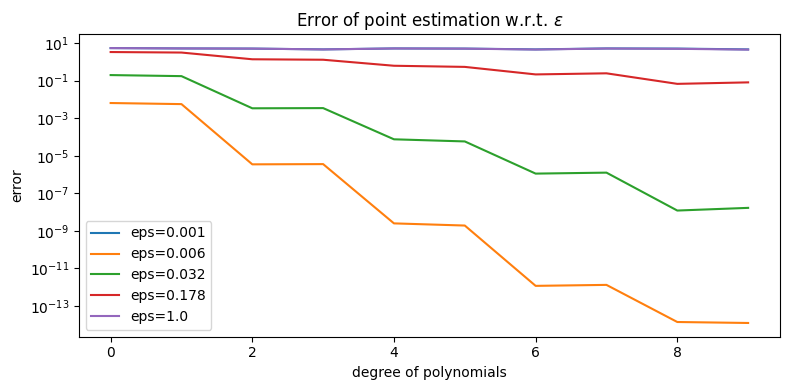

In [10]:
# study the error as a function of N for various values of variance
iter_num = 10
d_range = range(10)
eps_range = 10**np.linspace(-3, 0, 5)
poly_dict = {eps: {'poly': Hermite(t0, eps), 'error': np.zeros(d_range[-1]-d_range[0]+1)} for eps in eps_range}
for n in tqdm(d_range):
    error = 0
    for i in range(iter_num):
        func = random_sine_generator(seed=np.random.randint(10, 100))
        for sub_dict in poly_dict.values():
            sub_dict['error'][n-d_range[0]] += abs(sub_dict['poly'].ploy2path(func, n, t0) - func(t0))

plt.figure(figsize=(8, 4), dpi=100)
for name, sub_dict in poly_dict.items():
    plt.plot(d_range, sub_dict['error']/iter_num, label=f'eps={np.round(name, 3)}')
plt.legend()
plt.yscale('log')
plt.xlabel('degree of polynomials')
plt.ylabel('error')
plt.title(r'Error of point estimation w.r.t. $\epsilon$')
plt.tight_layout()
plt.show()

100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


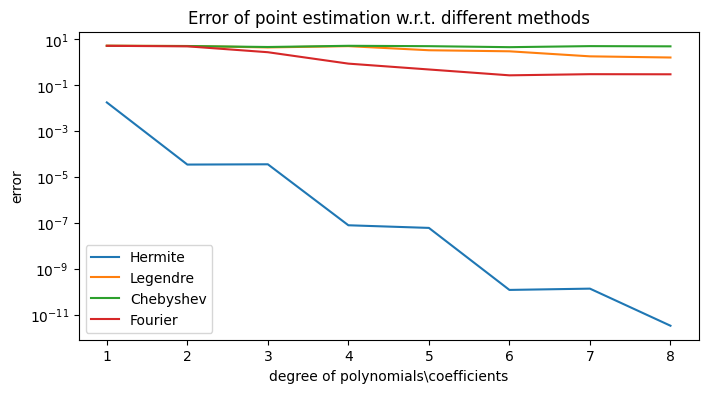

In [11]:
# study error as a function of N for various polynomials
iter_num = 10
d_range = range(1, 9)
poly_dict = {'Hermite': {'poly': Hermite(t0, eps), 'error': np.zeros(d_range[-1]-d_range[0]+1)},
             'Legendre': {'poly': Legendre(), 'error': np.zeros(d_range[-1]-d_range[0]+1)},
             'Chebyshev': {'poly': Chebyshev(), 'error': np.zeros(d_range[-1]-d_range[0]+1)},
             'Fourier': {'poly': Fourier(t_grid), 'error': np.zeros(d_range[-1]-d_range[0]+1)}}
for n in tqdm(d_range):
    error = 0
    for i in range(iter_num):
        func = random_sine_generator(seed=np.random.randint(10, 100))
        for sub_dict in poly_dict.values():
            sub_dict['error'][n-d_range[0]] += abs(sub_dict['poly'].ploy2path(func, n, t0) - func(t0))

plt.figure(figsize=(8, 4), dpi=100)
for name, sub_dict in poly_dict.items():
    sub_dict['error'] /= iter_num
    plt.plot(d_range, sub_dict['error'], label=name)
plt.legend()
plt.yscale('log')
plt.xlabel('degree of polynomials\coefficients')
plt.ylabel('error')
plt.title(r'Error of point estimation w.r.t. different methods')
plt.show()

### Point-wisely inverting signature

In [7]:
def point_sig(x, t_grid, N, eps=0.1):
    n = len(t_grid)
    x_recon = np.zeros(n)
    for i in range(n):
        if callable(x):
            hpoly = Hermite(t_grid[i], eps, start_poiint=t_grid[0])
            path_time = np.c_[t_grid, x(t_grid)*hpoly.weight(t_grid)]
        else:
            hpoly = Hermite(x[i], eps)
            path_time = np.c_[t_grid, x*hpoly.weight(t_grid)]
        sig = signature_of_path_iisignature(path_time, N+2)
        x_recon[i] = hpoly.sig2path(sig, N, t_grid)[i]
    return x_recon

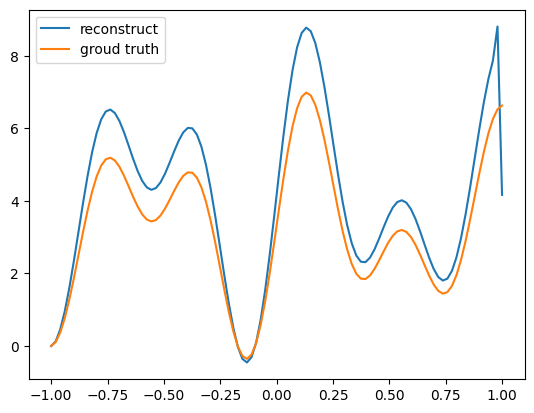

In [125]:
start, end, num_step = -1, 1, 100
t_grid = np.linspace(start, end, num_step)
func = random_sine_generator(seed=np.random.randint(1, 10000))
def x(t):
    return func(t)-func(t_grid[0])

eps = (end-start)/num_step/2
recon = point_sig(x, t_grid, 3, eps)
plt.plot(t_grid, recon, label='reconstruct')
plt.plot(t_grid, x(t_grid), label='groud truth')
plt.legend()

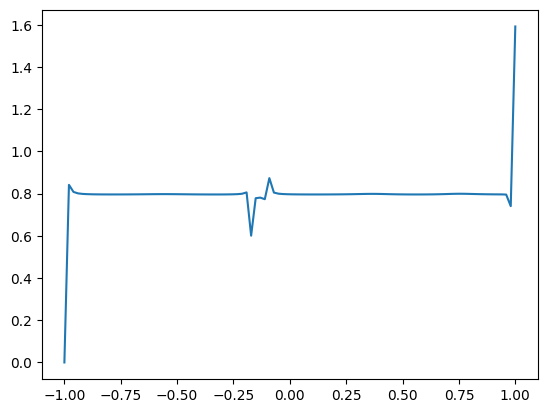

In [126]:
# ratio of original and reconstructed path
plt.plot(t_grid, x(t_grid)/recon, label='groud truth')

In [127]:
# check the constant ratio
idx = 4
print('point estimates at t=', np.round(t_grid[idx], 3), ' and x=', x(t_grid[idx]))
print('whole path:', x(t_grid))

hpoly = Hermite(t_grid[idx], eps, start_poiint=t_grid[0])
path_time = np.c_[t_grid, x(t_grid)*hpoly.weight(t_grid)]
print('weight:', np.round(hpoly.weight(t_grid), 3))

N = 3
sig = signature_of_path_iisignature(path_time, N+2)
print(sig)

point estimates at t= -0.919  and x= 1.2817629841890468
whole path: [ 0.          0.10597207  0.36816987  0.76894575  1.28176298  1.87309275
  2.50485589  3.13722276  3.73155258  4.25323961  4.67423834  4.97506347
  5.1461012   5.1881233   5.11195981  4.93735493  4.69109837  4.40458475
  4.11100249  3.84238559  3.62677518  3.4857304   3.43240088  3.47032814
  3.5930834   3.78478036  4.02142842  4.27302079  4.50618927  4.68720782
  4.78509516  4.77455518  4.63850399  4.36996351  3.97315087  3.46365742
  2.86768456  2.2203809   1.56339951  0.94185941  0.40094628 -0.01758032
 -0.2786952  -0.35696515 -0.23872288  0.0766229   0.57625428  1.23462372
  2.01510251  2.87247668  3.75610191  4.61347608  5.39395487  6.05232432
  6.55195569  6.86730148  6.98554375  6.9072738   6.64615891  6.22763232
  5.68671918  5.06517908  4.40819769  3.76089403  3.16492118  2.65542773
  2.25861509  1.9900746   1.85402342  1.84348343  1.94137077  2.12238932
  2.35555781  2.60715017  2.84379823  3.03549519  3.1582

In [128]:
for n in range(N+2):
    print((hpoly.a_sig(sig, n)-hpoly.a(x, n))**2)

0.00036106423070208496
0.0014801382591861667
0.09258987519177576
0.00238442581613822
83519.49351807368


In [129]:
recon[idx]-x(t_grid[idx])

0.3233219146558919

In [130]:
hpoly.recurrence(1)

(100.0, 91.91919191919192)

In [131]:
hpoly.ortho_factor(1)

0.025066282746310002